In [59]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random


In [60]:
words = open('../data/names.txt').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [61]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [62]:
len(words)

32033

In [63]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []

    #build context for each word
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

# create the train test splits
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])



torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [64]:
# update the MLP  to make it reuseable
n_embd = 10 # dimentionality of the the character embedding vector
n_hidden = 200 # number of hidden units in the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g) # character embeddings
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g) # first layer weights
b1 = torch.randn((n_hidden,), generator=g) # first layer bias
W2 = torch.randn((n_hidden, vocab_size), generator=g) # second layer weights
b2 =  torch.randn(vocab_size, generator=g) # second layer bias

parameters = [C, W1, b1, W2, b2]
print(sum(p.numel() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [65]:
# optimisation
max_steps = 200000
batch_size = 32
lossi = []


for i in range(max_steps):
    # sample a batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    x = Xtr[ix]
    y = Ytr[ix]

    # forward pass
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1) # flatten the embeddings -1 means infer the size
    hpre_activation = embcat @ W1 + b1
    h = torch.tanh(hpre_activation)
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, y)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # optimisation
    lr = 0.1 if i < 100000 else 0.01  # learnign rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 27.8817
  10000/ 200000: 2.8263
  20000/ 200000: 2.5130
  30000/ 200000: 2.8010
  40000/ 200000: 2.0541
  50000/ 200000: 2.6152
  60000/ 200000: 2.3549
  70000/ 200000: 2.0835
  80000/ 200000: 2.2652
  90000/ 200000: 2.2635
 100000/ 200000: 2.0810
 110000/ 200000: 2.3367
 120000/ 200000: 1.9650
 130000/ 200000: 2.4398
 140000/ 200000: 2.1524
 150000/ 200000: 2.1201
 160000/ 200000: 2.0399
 170000/ 200000: 1.8172
 180000/ 200000: 2.0771
 190000/ 200000: 1.7632


In [75]:
logits.shape

torch.Size([1, 27])

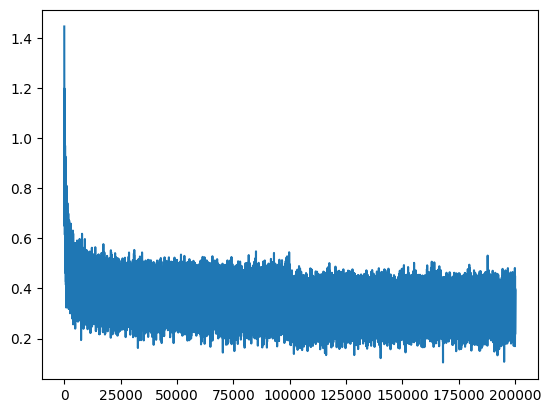

In [66]:
plt.plot(lossi)

What probability we expect?
Do we expect 27.88 at the start?
We expect much lower number. we expect the probability distribution that comes out is much uniform assigning equal probabilty to all the caharacters 
(-log(1/27) = 3.29)
There are 27 characters. At the initialisation we have no reason not to believe that any character would come after the context window.

What happens at the initialisation, NN is creating randomly prob dists for chracters. some chracters are very confidnet while others are not

In [67]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

In [72]:
# Above over smaller example
logits = torch.tensor([0.0, 5.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss
# with [0.0, 0.0, 0.0, 0.0] we get equal probs (tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))
# with [0.0, 0.0, 5.0, 0.0] we get the right prob by chance (high logit at index 2) (tensor([0.0067, 0.0067, 0.9800, 0.0067]), tensor(0.0202))
# with [0.0, 5.0, 0.0, 0.0] we get the high loss again (tensor([0.0067, 0.9800, 0.0067, 0.0067]), tensor(5.0200))

(tensor([0.0066, 0.9802, 0.0066, 0.0066]), tensor(5.0200))

In [99]:
# logits at the initialisation for the first iteration very be very high due to the bias term b2
# if we make the logits close to 0, first loss will be lower

# multiply b2 with 0 and w2 with small number (0.1) to make the logits close to 0
# optimisation

# update the MLP  to make it reuseable
n_embd = 10 # dimentionality of the the character embedding vector
n_hidden = 200 # number of hidden units in the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g) # character embeddings
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g) 
b1 = torch.randn((n_hidden,), generator=g) 
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # multiply this with 0.01 but we don't want to set it to 0 due vanishing gradient 
b2 =  torch.randn(vocab_size, generator=g) * 0 # multiply by 0 to make the logits close to 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.numel() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [100]:
# optimisation
max_steps = 200000
batch_size = 32
lossi = []


for i in range(max_steps):
    # sample a batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    x = Xtr[ix]
    y = Ytr[ix]

    # forward pass
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1) # flatten the embeddings -1 means infer the size
    hpre_activation = embcat @ W1 + b1
    h = torch.tanh(hpre_activation)
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, y)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # optimisation
    lr = 0.1 if i < 100000 else 0.01  # learnign rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break

      0/ 200000: 3.3221


In [81]:
#refactor the code to make it more modular
@torch.no_grad() # this is a decorator that tells pytorch not to track gradients in this function
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr), 
        'dev': (Xdev, Ydev), 
        'test': (Xte, Yte)
        }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpre_activation = embcat @ W1 + b1
    h = torch.tanh(hpre_activation)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('dev')


train 2.0695888996124268
dev 2.131074905395508


### Make sure initial logits are not tooo high, othersie optimisation will spend initial iterations in squashing high logits 

torch.Size([32, 200])
torch.Size([6400])


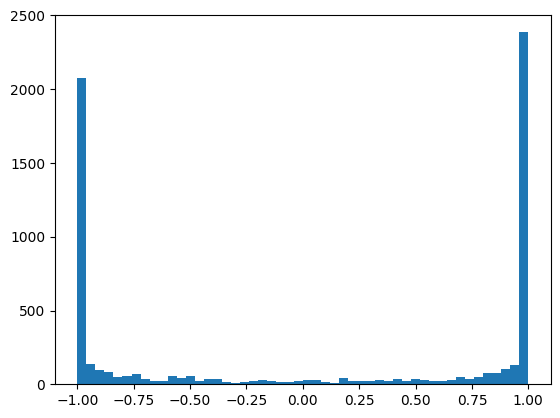

In [89]:
# lets look at the histogram of the hidden layer activations
# for this, we take h for the first iteration by putting a break point
print(h.shape)
# shape is (32, 200)
# we can flatten it to 32*200 = 6400
print(h.view(-1).shape)
# convert into numpy list and plot the histogram
plt.hist(h.view(-1).tolist(), bins=50);

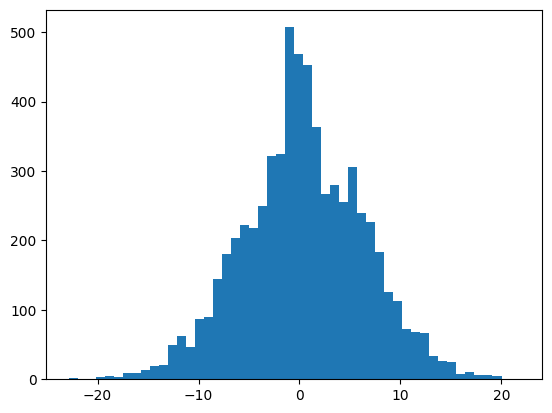

In [90]:
# we see most of the values take extreme 1, -1
# this is due to the tanh function
# why that is? we have to look at the hpre_activation
plt.hist(hpre_activation.view(-1).tolist(), bins=50);

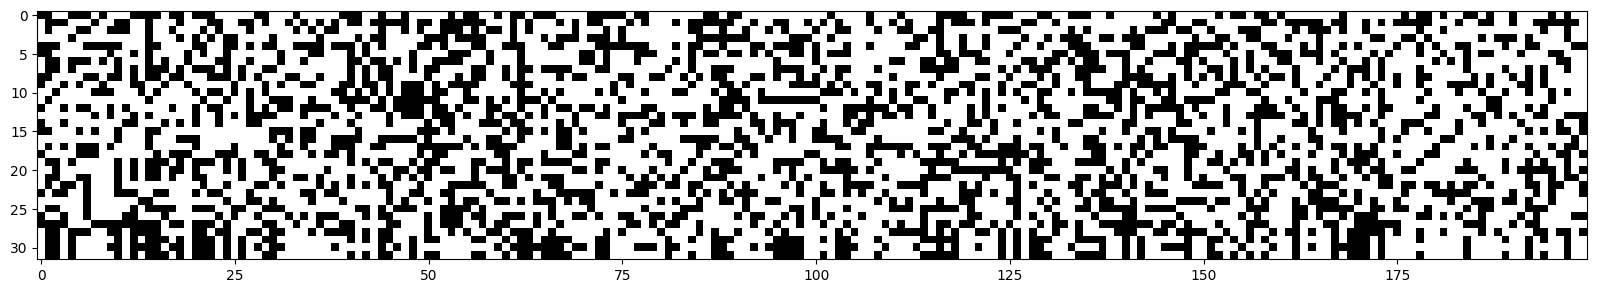

In [101]:
# thsi distribution of tanh is not good
# we investigate what happens when tanh is activated in the backward pass
# the line h = torch.tanh(hpre_activation) gets called for each example in the backward pass whihc has 200 neurons
# behind the scene, tanh has following operation 
# def tanh(self):
#     x = self.data
#     t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
#     out = Value(t, (self, ), 'tanh')
    
#     def _backward():
#       self.grad += (1 - t**2) * out.grad
#     out._backward = _backward

# in the backward pass we have to calculate the gradient of the loss with respect to the input of the tanh
# input of tanh has no impact on the output of the tanh due to (1- t**2) term, hence loss is not impacted
# gradient is zero and it vanishes, we stop the backpropagation thorugh that neuron unit whenever input is 1 or -1, tanh is active
# unit only gets activated when the input is 0, tanh unit is inactive and input just passes thorugh
# we can plot how often the tanh is active
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

# white means tanh active and gradient vanishes
# we look at the column of all whites which means that the neuron only fires for 1 or -1 and will not learn


almost all the activation functions has this problem. Neurons don't learn a the flat par of the curve. leaky relu suffers this problem a bit less. Some Nerons die due to high grad and then never learn. 
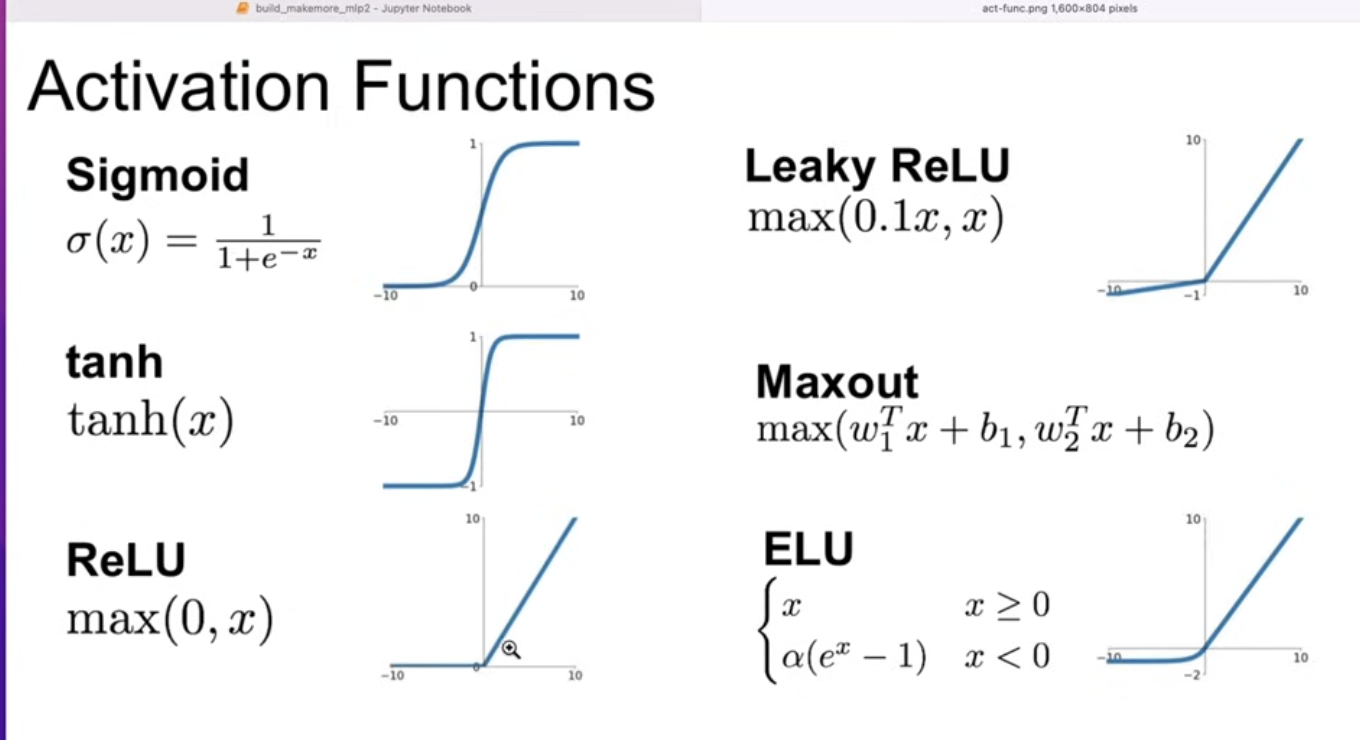

In [102]:
# to fix the issue to neurons not learninging we look at hpre_activation
# which is uniform gaussian distribution, hpre_activation is then multiplied by W2 and bias is added 
# hpre_activation = embcat @ W1 + b1 is too far off from the mean of 0
# we can multiply  b1 this by 0.01 to make it closer to 0
# we can multiply W1 by 0.2 to make the tanh unit not die
n_embd = 10 # dimentionality of the the character embedding vector
n_hidden = 200 # number of hidden units in the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g) # character embeddings
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g) * 0.2# multipy this with 0.01 to ensure tanh unit does not die for ever
b1 = torch.randn((n_hidden,), generator=g) * 0.01 # multiply this with 0.01 to ensure tanh unit does not die for ever
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # multiply this with 0.01 but we don't want to set it to 0 due vanishing gradient 
b2 =  torch.randn(vocab_size, generator=g) * 0 # multiply by 0 to make the logits close to 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.numel() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [103]:
# optimisation
max_steps = 200000
batch_size = 32
lossi = []


for i in range(max_steps):
    # sample a batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    x = Xtr[ix]
    y = Ytr[ix]

    # forward pass
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1) # flatten the embeddings -1 means infer the size
    hpre_activation = embcat @ W1 + b1
    h = torch.tanh(hpre_activation)
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, y)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # optimisation
    lr = 0.1 if i < 100000 else 0.01  # learnign rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break

      0/ 200000: 3.3135


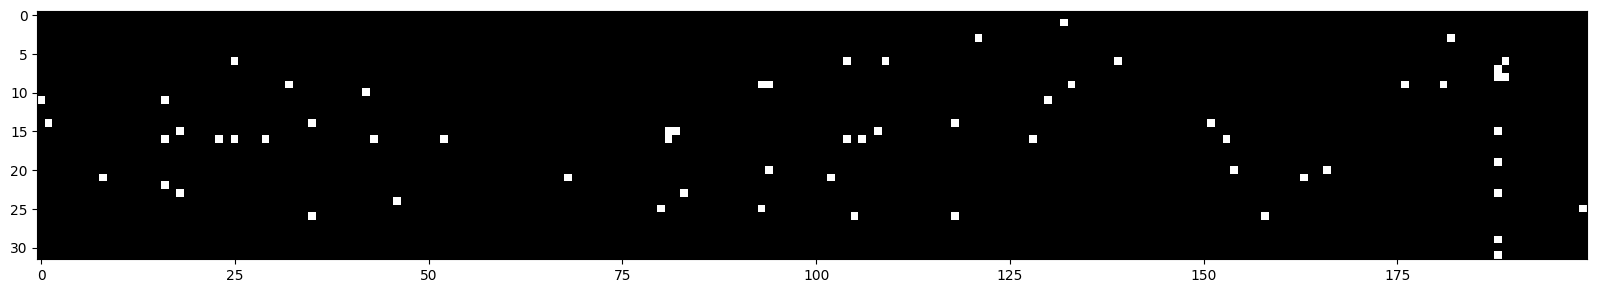

In [104]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')


Now the distribution looks much better. white shows there are less neurons that are alwyas dead
now run all the iterations

In [105]:
# optimisation
max_steps = 200000
batch_size = 32
lossi = []


for i in range(max_steps):
    # sample a batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    x = Xtr[ix]
    y = Ytr[ix]

    # forward pass
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1) # flatten the embeddings -1 means infer the size
    hpre_activation = embcat @ W1 + b1
    h = torch.tanh(hpre_activation)
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, y)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # optimisation
    lr = 0.1 if i < 100000 else 0.01  # learnign rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    

      0/ 200000: 3.2465
  10000/ 200000: 1.9043
  20000/ 200000: 1.9004
  30000/ 200000: 1.9465
  40000/ 200000: 2.1656
  50000/ 200000: 2.0071
  60000/ 200000: 2.0826
  70000/ 200000: 2.4228
  80000/ 200000: 2.3109
  90000/ 200000: 2.1167
 100000/ 200000: 2.2166
 110000/ 200000: 1.8038
 120000/ 200000: 2.2112
 130000/ 200000: 1.9618
 140000/ 200000: 1.8056
 150000/ 200000: 2.4102
 160000/ 200000: 2.1829
 170000/ 200000: 1.6967
 180000/ 200000: 1.9343
 190000/ 200000: 2.1057


In [106]:
@torch.no_grad() # this is a decorator that tells pytorch not to track gradients in this function
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr), 
        'dev': (Xdev, Ydev), 
        'test': (Xte, Yte)
        }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpre_activation = embcat @ W1 + b1
    h = torch.tanh(hpre_activation)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('dev')


train 2.0357086658477783
dev 2.1029489040374756


tensor(0.0031) tensor(3.1092)
tensor(0.0023) tensor(0.9956)


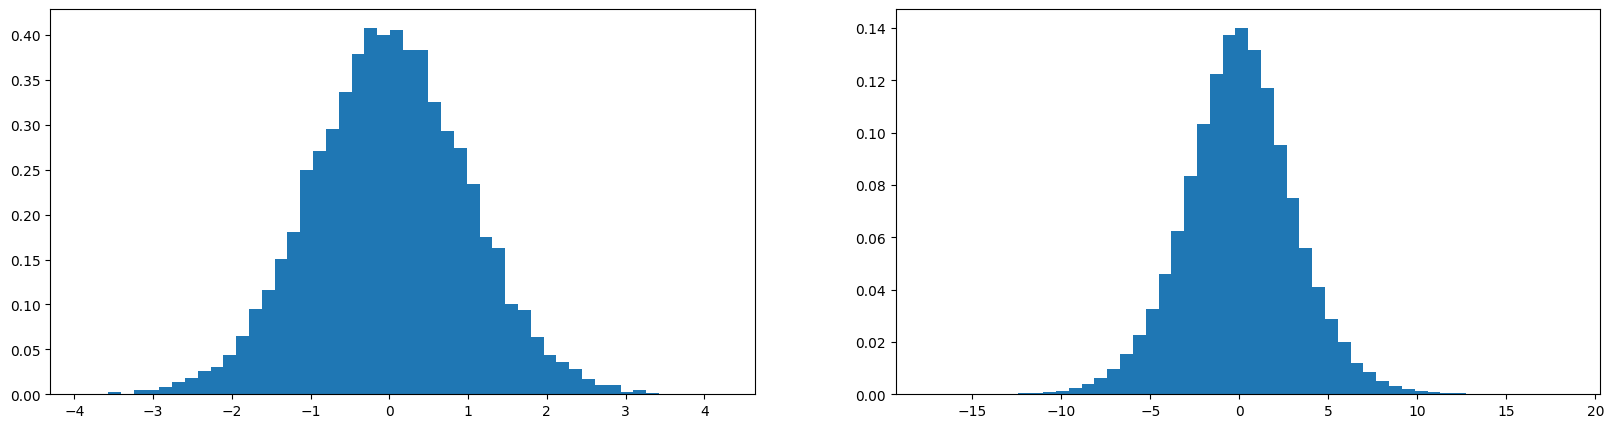

In [107]:
# we multiplied Ws and Bs with small numbers. where these came from?
# we need to replace them with systematic initialisation
# let's start with a code

x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w

print(y.mean(), y.std())
print(x.mean(), x.std())

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.hist(x.view(-1).tolist(), bins=50, density=True);
plt.subplot(1, 2, 2)
plt.hist(y.view(-1).tolist(), bins=50, density=True);

# mean of x is 0 and std is 1
# mean of y is 0 and std is 10 (10 times the std of x) after the matrix multiplication
# we want to keep the std of y same as x
# how to scale W to keep the std of y same as x


tensor(0.0209) tensor(1.0005)
tensor(0.0026) tensor(1.0191)


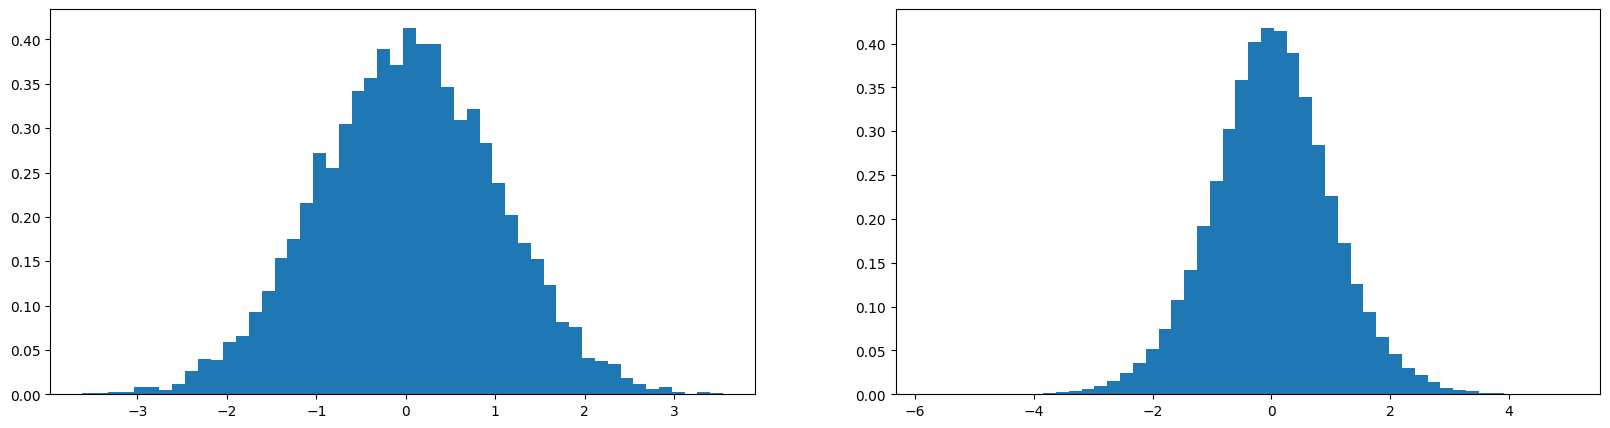

In [110]:
# if we scale W down, we can keep the std of y same as x
# we can scale W by 1/sqrt(n) where n is the number of input units
# this is called Kaiming initialisation
# this is based on the paper "He, K., Zhang, X., Ren, S., & Sun, J. (2015). Delving deep into rectifiers: Surpassing human-level performance on imagenet classification. In Proceedings of the IEEE international conference on computer vision (pp. 1026-1034)."
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / (10**0.5)
y = x @ w

print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.hist(x.view(-1).tolist(), bins=50, density=True);
plt.subplot(1, 2, 2)
plt.hist(y.view(-1).tolist(), bins=50, density=True);

In [113]:
# we can aslo use pytorch for kaiming initialisation
# torch.nn.init.kaiming_normal_(w, mode='fan_in', nonlinearity='linear')
# mode='fan_in' means we scale by 1/sqrt(n)
# nonlinearity='linear' means we are using linear activation function
# we can use 'relu' for ReLU activation function
# gain will be different for different activation functions
# gain for ReLU is sqrt(2), linear is 1

#gaussian is 
print((torch.randn(10000) ).std())
#  we scale dow gaussian by let's say 0.2 to make it std 0.2
print((torch.randn(10000) * 0.2).std())
# since we are using tanh activation function, we can use gain = 5/3
# gain is the factor we multiply the std of the gaussian with to get the desired std

# (5/3) / sqrt(fan_in)
# fan_in is the W1 shape[0] = n_embd*block_size = 10*3 = 30
# we can use gain = 5/3 / sqrt(30) = 0.3

# now we can change the numebrs in the code
n_embd = 10 
n_hidden = 200 

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g) # character embeddings
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g) * (5/3)/((n_embd*block_size)**0.5)# 0.2
b1 = torch.randn((n_hidden,), generator=g) * 0.01 
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 =  torch.randn(vocab_size, generator=g) * 0 

parameters = [C, W1, b1, W2, b2]
print(sum(p.numel() for p in parameters))
for p in parameters:
    p.requires_grad = True


tensor(1.0011)
tensor(0.2013)
11897


In [114]:
# re-train the network
# optimisation
max_steps = 200000
batch_size = 32
lossi = []


for i in range(max_steps):
    # sample a batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    x = Xtr[ix]
    y = Ytr[ix]

    # forward pass
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1) # flatten the embeddings -1 means infer the size
    hpre_activation = embcat @ W1 + b1
    h = torch.tanh(hpre_activation)
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, y)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # optimisation
    lr = 0.1 if i < 100000 else 0.01  # learnign rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    

      0/ 200000: 3.3179
  10000/ 200000: 2.1910
  20000/ 200000: 2.3270
  30000/ 200000: 2.5396
  40000/ 200000: 1.9468
  50000/ 200000: 2.3331
  60000/ 200000: 2.3852
  70000/ 200000: 2.1173
  80000/ 200000: 2.3159
  90000/ 200000: 2.2010
 100000/ 200000: 1.8591
 110000/ 200000: 2.0881
 120000/ 200000: 1.9389
 130000/ 200000: 2.3913
 140000/ 200000: 2.0949
 150000/ 200000: 2.1458
 160000/ 200000: 1.7824
 170000/ 200000: 1.7249
 180000/ 200000: 1.9752
 190000/ 200000: 1.8614


In [115]:
@torch.no_grad() # this is a decorator that tells pytorch not to track gradients in this function
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr), 
        'dev': (Xdev, Ydev), 
        'test': (Xte, Yte)
        }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpre_activation = embcat @ W1 + b1
    h = torch.tanh(hpre_activation)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('dev')


train 2.0376641750335693
dev 2.106989622116089


With new innovations suhc as Batch Normalization, ADAM optimiser, etc. this initialisation is not that important anymore. we intoduce Batch Normalisation 

## Batch Normalisation
It is based on the paper "Ioffe, S., & Szegedy, C. (2015). Batch normalization: Accelerating deep network training by reducing internal covariate shift. arXiv preprint arXiv:1502.03167."

we have hidden states pre-actications` hpre_activation` we do not want to eb too small so that tanh is not learning also we do not them to be too large so that tanh is saturated. Infact we want them to be roughly gaussian. Batch normalisation paper says why not take these intial states and normalise then using gaussian. Gaussian is perfectly differentiable. 

It is much easier to use BN for deep NNs because manually scaling Ws is cumbersome
 we do that in the following code:

In [116]:
n_embd = 10 
n_hidden = 200 

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g) # character embeddings
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g) * (5/3)/((n_embd*block_size)**0.5)# 0.2
b1 = torch.randn((n_hidden,), generator=g) * 0.01 
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 =  torch.randn(vocab_size, generator=g) * 0 

bngain = torch.ones((1, n_hidden)) # Batch norm gamma (scale/gain) parameter
bnbias = torch.zeros((1, n_hidden)) # Batch norm beta (shift) parameter


parameters = [C, W1, b1, W2, b2]
print(sum(p.numel() for p in parameters))
for p in parameters:
    p.requires_grad = True


11897


In [117]:
# re-train the network
# optimisation
max_steps = 200000
batch_size = 32
lossi = []


for i in range(max_steps):
    # sample a batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    x = Xtr[ix]
    y = Ytr[ix]

    # forward pass
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1) # flatten the embeddings -1 means infer the size
    hpre_activation = embcat @ W1 + b1
    # BATCH NORMALIZATION
    # 1. calcualte the mean and std of hpre_activation over all the elements batch (0)
    # 2. to normalise, subtract the mean and divide by std
    # 3. scale and shift the normalised values by gamma and beta
    # we want states to be gaussian just at the initialisation not always and 
    # we want backpropagation to guide us when to make the states gaussian
    # we intorduce bngain and bnbias at the initialisation step 
    hpre_activation = bngain * (hpre_activation - hpre_activation.mean(0, keepdim=True)) / hpre_activation.std(0, keepdim=True) + bnbias
    h = torch.tanh(hpre_activation)
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, y)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # optimisation
    lr = 0.1 if i < 100000 else 0.01  # learnign rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    

      0/ 200000: 3.3147
  10000/ 200000: 2.1942
  20000/ 200000: 2.3443
  30000/ 200000: 2.4160
  40000/ 200000: 1.9913
  50000/ 200000: 2.2978
  60000/ 200000: 2.5254
  70000/ 200000: 2.0707
  80000/ 200000: 2.3107
  90000/ 200000: 2.0663
 100000/ 200000: 1.9933
 110000/ 200000: 2.3179
 120000/ 200000: 1.9123
 130000/ 200000: 2.4505
 140000/ 200000: 2.4321
 150000/ 200000: 2.2003
 160000/ 200000: 2.0463
 170000/ 200000: 1.8839
 180000/ 200000: 1.9983
 190000/ 200000: 1.8873


In [118]:
@torch.no_grad() # this is a decorator that tells pytorch not to track gradients in this function
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr), 
        'dev': (Xdev, Ydev), 
        'test': (Xte, Yte)
        }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpre_activation = embcat @ W1 + b1
    hpre_activation = bngain * (hpre_activation - hpre_activation.mean(0, keepdim=True)) / hpre_activation.std(0, keepdim=True) + bnbias
    h = torch.tanh(hpre_activation)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('dev')

train 2.0785984992980957
dev 2.112783670425415


In [119]:
# how to feed the network with the test data
# we calibrate the batch norm parameters on the training data

with torch.no_grad():
    emb = C[Xte]
    embcat = emb.view(emb.shape[0], -1)
    hpre_activation = embcat @ W1 + b1
    # hpre_activation = bngain * (hpre_activation - hpre_activation.mean(0, keepdim=True)) / hpre_activation.std(0, keepdim=True) + bnbias
    
    # measure the mean/std over the entire training data
    bnmean = hpre_activation.mean(0, keepdim=True)
    bnstd = hpre_activation.std(0, keepdim=True)



In [120]:
@torch.no_grad() 
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr), 
        'dev': (Xdev, Ydev), 
        'test': (Xte, Yte)
        }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpre_activation = embcat @ W1 + b1
    # hpre_activation = bngain * (hpre_activation - hpre_activation.mean(0, keepdim=True)) / hpre_activation.std(0, keepdim=True) + bnbias
    # mean/std are fixed, now we can use one test example to get the predictions
    hpre_activation = bngain * (hpre_activation - bnmean) / bnstd + bnbias
    h = torch.tanh(hpre_activation)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('dev')

train 2.078770637512207
dev 2.113060712814331


In [121]:
# we do nto want to calcualte meam/std after the traning we cna caulcat ethen in the training
# re-train the network
# optimisation

n_embd = 10 
n_hidden = 200 

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g) # character embeddings
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g) * (5/3)/((n_embd*block_size)**0.5)# 0.2
b1 = torch.randn((n_hidden,), generator=g) * 0.01 
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 =  torch.randn(vocab_size, generator=g) * 0 

bngain = torch.ones((1, n_hidden)) 
bnbias = torch.zeros((1, n_hidden)) 
bnmean_running = torch.zeros((1, n_hidden)) # running mean its zeros due to the wya to initilized weight to be zero 
bnstd_running = torch.ones((1, n_hidden)) # running std, it's one de to the way we initilized the weights to be one


parameters = [C, W1, b1, W2, b2]
print(sum(p.numel() for p in parameters))
for p in parameters:
    p.requires_grad = True


max_steps = 200000
batch_size = 32
lossi = []


for i in range(max_steps):
    # sample a batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    x = Xtr[ix]
    y = Ytr[ix]

    # forward pass
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1) # flatten the embeddings -1 means infer the size
    hpre_activation = embcat @ W1 + b1
    # RUNNING MEAN AND STD UPDATE
    bnmeani = hpre_activation.mean(0, keepdim=True)
    bnstdi = hpre_activation.std(0, keepdim=True)
    hpre_activation = bngain * (hpre_activation - bnmeani) / bnstdi + bnbias
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh(hpre_activation)
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, y)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # optimisation
    lr = 0.1 if i < 100000 else 0.01  # learnign rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    

11897
      0/ 200000: 3.3147
  10000/ 200000: 2.1942
  20000/ 200000: 2.3443
  30000/ 200000: 2.4160
  40000/ 200000: 1.9913
  50000/ 200000: 2.2978
  60000/ 200000: 2.5254
  70000/ 200000: 2.0707
  80000/ 200000: 2.3107
  90000/ 200000: 2.0663
 100000/ 200000: 1.9933
 110000/ 200000: 2.3179
 120000/ 200000: 1.9123
 130000/ 200000: 2.4505
 140000/ 200000: 2.4321
 150000/ 200000: 2.2003
 160000/ 200000: 2.0463
 170000/ 200000: 1.8839
 180000/ 200000: 1.9983
 190000/ 200000: 1.8873


In [122]:
@torch.no_grad() 
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr), 
        'dev': (Xdev, Ydev), 
        'test': (Xte, Yte)
        }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpre_activation = embcat @ W1 + b1
    # hpre_activation = bngain * (hpre_activation - hpre_activation.mean(0, keepdim=True)) / hpre_activation.std(0, keepdim=True) + bnbias
    # mean/std are fixed, now we can use one test example to get the predictions
    hpre_activation = bngain * (hpre_activation - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpre_activation)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('dev')

train 2.078073263168335
dev 2.1128156185150146


In [ ]:
# BN layer has its own bias therefore we can remove the b1
# we do nto want to calcualte meam/std after the traning we cna caulcat ethen in the training
# re-train the network
# optimisation

n_embd = 10 
n_hidden = 200 

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g) # character embeddings
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g) * (5/3)/((n_embd*block_size)**0.5)# 0.2
# b1 = torch.randn((n_hidden,), generator=g) * 0.01 
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 =  torch.randn(vocab_size, generator=g) * 0 

bngain = torch.ones((1, n_hidden)) 
bnbias = torch.zeros((1, n_hidden)) 
bnmean_running = torch.zeros((1, n_hidden)) # running mean its zeros due to the wya to initilized weight to be zero 
bnstd_running = torch.ones((1, n_hidden)) # running std, it's one de to the way we initilized the weights to be one


parameters = [C, W1, b1, W2, b2]
print(sum(p.numel() for p in parameters))
for p in parameters:
    p.requires_grad = True


max_steps = 200000
batch_size = 32
lossi = []


for i in range(max_steps):
    # sample a batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    x = Xtr[ix]
    y = Ytr[ix]

    # forward pass
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1) # flatten the embeddings -1 means infer the size
    hpre_activation = embcat @ W1 #+ b1 # hidden layer pre activation, NOTE: bias is removed
    # RUNNING MEAN AND STD UPDATE
    bnmeani = hpre_activation.mean(0, keepdim=True)
    bnstdi = hpre_activation.std(0, keepdim=True)
    hpre_activation = bngain * (hpre_activation - bnmeani) / bnstdi + bnbias
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh(hpre_activation)
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, y)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # optimisation
    lr = 0.1 if i < 100000 else 0.01  # learnign rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    

In [ ]:
# loss log
# original
train 2.1245384216308594
dev 2.168116807937622
# fix softmax confidently wrong:
train 2.0695888996124268
dev 2.131074905395508
# fix tanh layer too saturated at initialization:
train 2.0357086658477783
dev 2.1029489040374756
# use kaiming initialization instead of manual scaling:
train 2.0376641750335693
dev 2.106989622116089


In [82]:
g = torch.Generator().manual_seed(214748364 + 10) # create a sampel from the model

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)

        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if ix is special token '.', break
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))


nathalixhida.
codora.
ron.
oleezaravenyana.
addixnna.
wit.
tream.
heen.
grudefa.
ker.
ran.
nana.
isi.
magna.
ansiona.
ken.
aivyannaston.
aph.
tilla.
fani.


### torch Batch Norm

`torch.nn.BatchNorm1d` has following parameter:
- `num_features` - that same as we used `n_hidden` which is 200
- `momentum` - this is to run running mean and std. we sued 0.001. For large batch sizes we could use higher momentum. 
- `track running state ` - we keep it True unless this module does not track such statistics, and initializes statistics buffers running_mean and running_var as None

## Real World Example
ResNet50
for classfication, image feeds into Resnet, there are many layers with repeating structure that is predicting what's inside that picture. That repeatings structure is made of blocks that are sequatially stacked up in the deep neural netowrks. The block is called Bottleneck block.

Convolution layers are used for images that are similar to linera layer but have spatial structure. Conv layers do Wx+b but do it on over-lapping patches of the input. 
Each block consits of:
1. Convolution layer
2. Batch Norm layer
3. relu layer

Simialr to what we did above which consisted of 
1. Linear layer
2. Batch norm layer
3. Tanh lauer



### Modular code

In [135]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5 # kaiming initialisation
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if  self.bias is None else [self.bias])
    

class BatchNorm1d:

    def __init__(self, dim, eps = 1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True # training mode
        # parameters trained with backpropagation
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running momentum update)
        self.running_mean = torch.zeros(dim) # not part of backprop
        # note: using var instead of std, just to follow the notation in the paper
        self.running_var = torch.ones(dim) # not part of backprop

    def __call__(self, x):
        # forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean, in training mode batch mean is used
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
    
        xhat = (x-xmean) / torch.sqrt(xvar + self.eps) # normalise
        self.out = self.gamma* xhat + self.beta # scale and shift

        # update the running mean and variance
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean # exponential moving average
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)


# stack the layers
C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd*block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

with torch.no_grad():
    # make last layer small
    layers[-1].weight *= 0.1

    #apply gain to all layers
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3 # this gain is necessary to resist the Tanh saturation, because these are stacked Linear layers

parameters = [C]+[p for layer in layers for p in layer.parameters()] 
print(sum(p.numel() for p in parameters))
for p in parameters:
    p.requires_grad = True




46497


In [136]:
max_steps = 200000
batch_size = 32
lossi = []


for i in range(max_steps):
    # sample a batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    xb = Xtr[ix]
    yb = Ytr[ix]

    # forward pass
    # is jsut the linear application of the layers
    emb = C[xb]
    x = emb.view(emb.shape[0], -1) # flatten the embeddings -1 means infer the size
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01  # learnign rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')  
    lossi.append(loss.log10().item())

    break # remove this to train the model



      0/ 200000: 3.2962


layer 1 (      Tanh): mean -0.02, std 0.75, saturated: 20.25%
layer 3 (      Tanh): mean -0.00, std 0.69, saturated: 8.38%
layer 5 (      Tanh): mean +0.00, std 0.67, saturated: 6.62%
layer 7 (      Tanh): mean -0.01, std 0.66, saturated: 5.47%
layer 9 (      Tanh): mean -0.02, std 0.66, saturated: 6.12%


Text(0.5, 1.0, 'activation distribution')

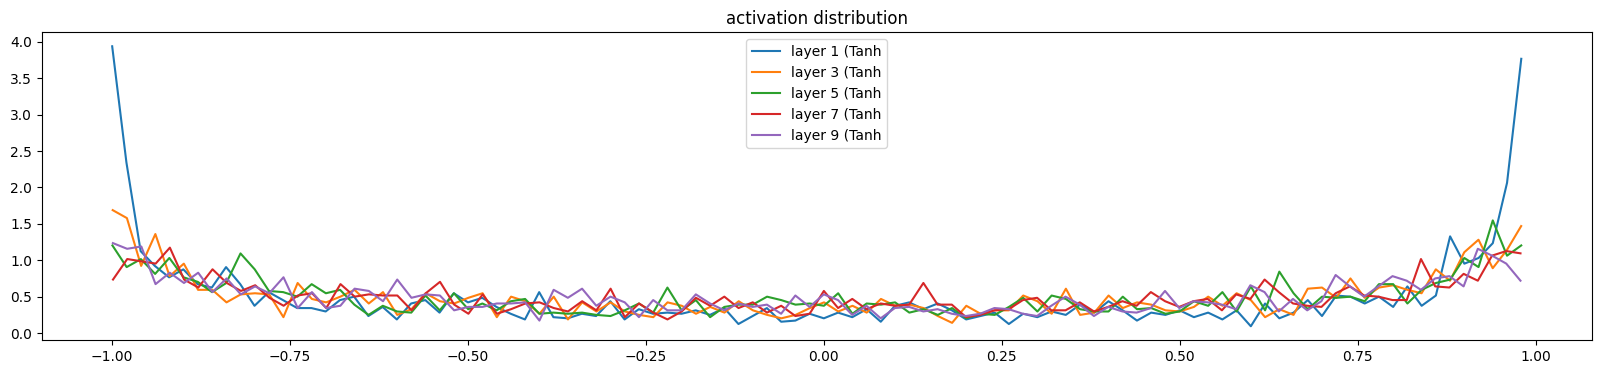

In [137]:
# forward pass activations histogram
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]): # exclude the last layer
    if isinstance(layer , Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends)
plt.title('activation distribution')


If gains were too high e.g. 5, saturation for all the layers is too high 65% and NN does not stabalizes.
layer 1 (      Tanh): mean -0.04, std 0.91, saturated: 65.00%
layer 3 (      Tanh): mean +0.01, std 0.91, saturated: 63.59%
layer 5 (      Tanh): mean -0.02, std 0.91, saturated: 65.25%
layer 7 (      Tanh): mean -0.02, std 0.92, saturated: 66.41%
layer 9 (      Tanh): mean -0.04, std 0.91, saturated: 65.09%

we have to adjust the gain to stabalise the layers and this is due to Tanh activation. it shrinks the input between -1 and 1. To resist it we add some gain. However if there was no Tanh layer, we would ahve just a sandwitch of Linear layers. in this case 

layer 1 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 3 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 7 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 9 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

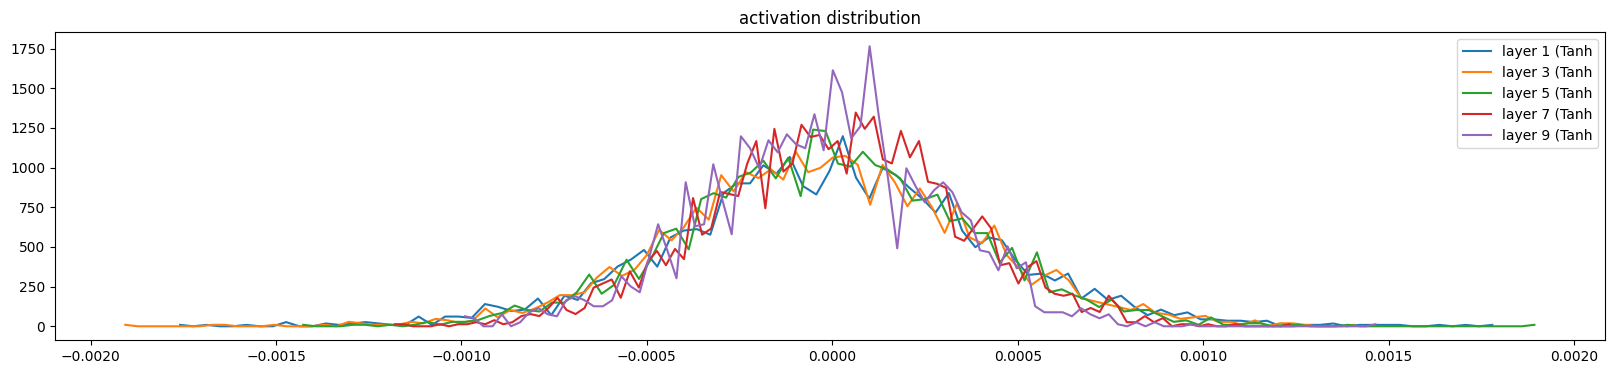

In [131]:
# forward pass grad histogram
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]): # exclude the last layer
    if isinstance(layer , Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends)
plt.title('activation distribution')

weight   (27, 10) | mean +0.000000 | std 8.020539e-03 | grad:data ratio 8.012635e-03
weight  (30, 100) | mean +0.000246 | std 9.241082e-03 | grad:data ratio 4.881094e-02
weight (100, 100) | mean +0.000113 | std 7.132884e-03 | grad:data ratio 6.964625e-02
weight (100, 100) | mean -0.000086 | std 6.234306e-03 | grad:data ratio 6.073742e-02
weight (100, 100) | mean +0.000052 | std 5.742189e-03 | grad:data ratio 5.631484e-02
weight (100, 100) | mean +0.000032 | std 5.672207e-03 | grad:data ratio 5.570126e-02
weight  (100, 27) | mean -0.000082 | std 1.209416e-02 | grad:data ratio 1.160106e-01


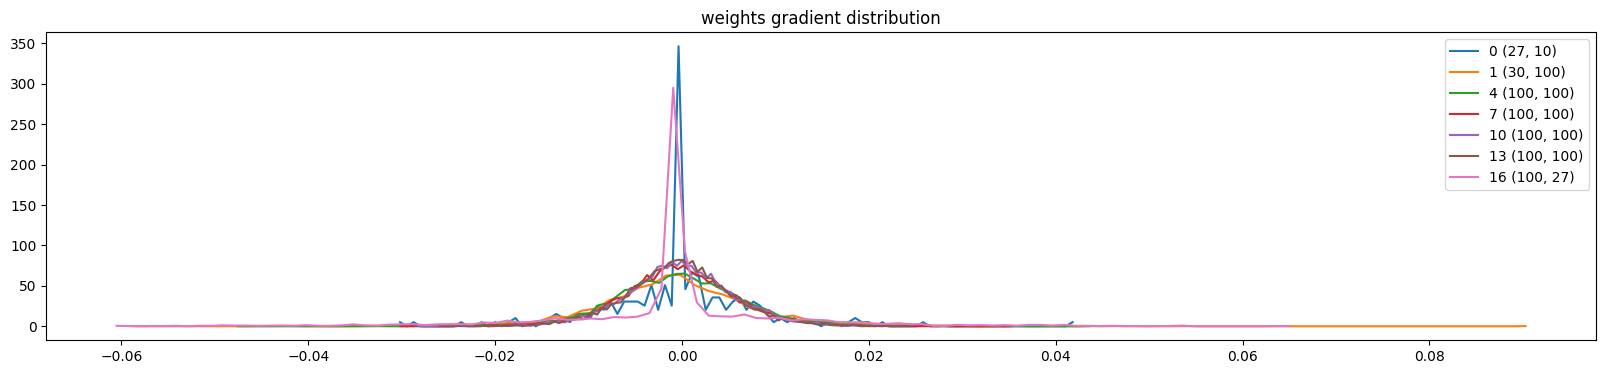

In [149]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

In the above plot, training int he last layer is 10x faster than the other layers, we look at the update of gradient to data ratio that will give us indication if there is any trouble in any of hte layers.

We add this parameter below

In [141]:
max_steps = 200000
batch_size = 32
lossi = []
ud = [] # grad update to data ratio

for i in range(max_steps):
    # sample a batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    xb = Xtr[ix]
    yb = Ytr[ix]

    # forward pass
    # is jsut the linear application of the layers
    emb = C[xb]
    x = emb.view(emb.shape[0], -1) # flatten the embeddings -1 means infer the size
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01  # learnign rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')  
    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        break # remove this to train the model



      0/ 200000: 2.0273


In [147]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2870


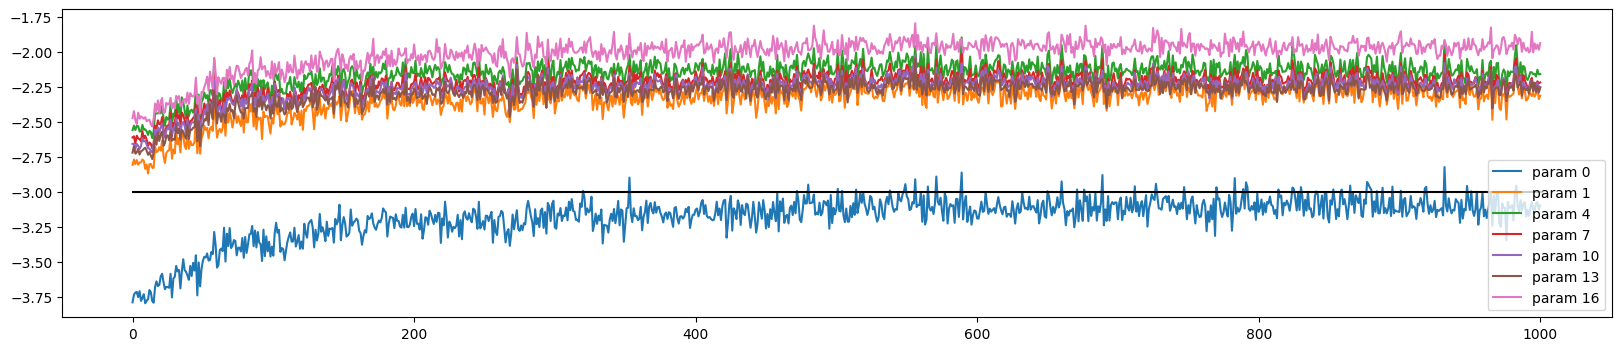

In [148]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [146]:
# add  BatchNorm layer
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True



47024
